In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/dogs-vs-cats.zip'
extract_dir = '/content/'

try:
    # Unzipping the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction successful! Files are unzipped to {extract_dir}")
except zipfile.BadZipFile as e:
    print("Error: The file appears to be corrupted or is not a valid zip file.")
    print(e)

Extraction successful! Files are unzipped to /content/


Unzip the train.zip file at /content/

In [ ]:
import zipfile
import os

zip_file_path = '/content/train.zip'
extract_dir = '/content/'

try:
    # Unzipping the dataset
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extraction successful! Files are unzipped to {extract_dir}")
except zipfile.BadZipFile as e:
    print("Error: The file appears to be corrupted or is not a valid zip file.")
    print(e)

Extraction successful! Files are unzipped to /content/


Split the data into train data and test data

In [ ]:
import os
import random
import shutil

# Path where images are stored
dataset_dir = '/content/train'
train_dir = '/content/dataset/train'  # Directory to store training data
test_dir = '/content/dataset/test'    # Directory to store testing data

# Create directories for train and test datasets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all images in the dataset directory
all_images = os.listdir(dataset_dir)

# Shuffle the list of images to ensure randomness
random.shuffle(all_images)

# Calculations to split the data into 70% train & 30% test
split_point = int(0.7 * len(all_images))  # 80% for training
train_images = all_images[:split_point]   # First 80% of images for training
test_images = all_images[split_point:]    # Remaining 20% for testing

# Move training images to the train directory
for img in train_images:
    shutil.move(os.path.join(dataset_dir, img), train_dir)

# Move testing images to the test directory
for img in test_images:
    shutil.move(os.path.join(dataset_dir, img), test_dir)

# Making sure if images are moved in right directories
print(f"Training images: {len(train_images)} moved to {train_dir}")
print(f"Testing images: {len(test_images)} moved to {test_dir}")

Training images: 17500 moved to /content/dataset/train
Testing images: 7500 moved to /content/dataset/test


Move the images to class spefic folders

In [ ]:
import os
import shutil

# Paths to train and test directories
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

# Create directories for cats and dogs in train and test folders
os.makedirs(f'{train_dir}/cats', exist_ok=True)
os.makedirs(f'{train_dir}/dogs', exist_ok=True)
os.makedirs(f'{test_dir}/cats', exist_ok=True)
os.makedirs(f'{test_dir}/dogs', exist_ok=True)

# Define the number of images to move
train_limit = 17500  # images per class for training
test_limit = 7500  #  images per class for testing

# Initialize counters
train_cats_moved = 0
train_dogs_moved = 0
test_cats_moved = 0
test_dogs_moved = 0

# Move images to their respective class directories in the training folder
for img in os.listdir(train_dir):
    if 'cat' in img and train_cats_moved < train_limit:
        shutil.move(os.path.join(train_dir, img), f'{train_dir}/cats')
        train_cats_moved += 1
    elif 'dog' in img and train_dogs_moved < train_limit:
        shutil.move(os.path.join(train_dir, img), f'{train_dir}/dogs')
        train_dogs_moved += 1

    # Stop if both categories reach their limit
    if train_cats_moved >= train_limit and train_dogs_moved >= train_limit:
        break

# Move images to their respective class directories in the testing folder
for img in os.listdir(test_dir):
    if 'cat' in img and test_cats_moved < test_limit:
        shutil.move(os.path.join(test_dir, img), f'{test_dir}/cats')
        test_cats_moved += 1
    elif 'dog' in img and test_dogs_moved < test_limit:
        shutil.move(os.path.join(test_dir, img), f'{test_dir}/dogs')
        test_dogs_moved += 1

    # Stop if both categories reach their limit
    if test_cats_moved >= test_limit and test_dogs_moved >= test_limit:
        break

print("Images successfully moved to class-specific folders with the specified limits.")


Images successfully moved to class-specific folders with the specified limits.


Check to makesure if images have moved to right folders

In [ ]:
import os

# Check directory structure of training data
for root, dirs, files in os.walk('/content/dataset/train'):
    print(f'Found directory: {root}')
    print(f'Files: {files[:5]}')  # Display the first 5 files for each directory

# Check directory structure of testing data
for root, dirs, files in os.walk('/content/dataset/test'):
    print(f'Found directory: {root}')
    print(f'Files: {files[:5]}')  # Display the first 5 files for each directory


Found directory: /content/dataset/train
Files: []
Found directory: /content/dataset/train/dogs
Files: ['dog.899.jpg', 'dog.10921.jpg', 'dog.6451.jpg', 'dog.10470.jpg', 'dog.4715.jpg']
Found directory: /content/dataset/train/cats
Files: ['cat.8140.jpg', 'cat.1065.jpg', 'cat.10510.jpg', 'cat.2647.jpg', 'cat.7887.jpg']
Found directory: /content/dataset/test
Files: []
Found directory: /content/dataset/test/dogs
Files: ['dog.12198.jpg', 'dog.1878.jpg', 'dog.6306.jpg', 'dog.11757.jpg', 'dog.8592.jpg']
Found directory: /content/dataset/test/cats
Files: ['cat.7282.jpg', 'cat.12098.jpg', 'cat.2706.jpg', 'cat.8420.jpg', 'cat.6527.jpg']


SRGAN Netwroks


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Generator Model
def build_generator(num_residual_blocks=12):
    inputs = Input(shape=(32, 32, 3))
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU()(x)
    for _ in range(num_residual_blocks):
        res = Conv2D(64, kernel_size=3, padding='same')(x)
        res = PReLU()(res)
        res = Conv2D(64, kernel_size=3, padding='same')(res)
        x = Add()([x, res])
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Discriminator Model
def build_discriminator():
    inputs = Input(shape=(128, 128, 3))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)

    for filters in [128, 256, 512]:
        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(negative_slope=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

# Instantiate models
generator = build_generator(num_residual_blocks=12)
discriminator = build_discriminator()

# Compile models with adjusted learning rates
generator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Load VGG19 model pretrained on ImageNet and freeze layers
def build_vgg19():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)  # Choose an intermediate layer
    return model

# Instantiate the VGG19 model for perceptual loss calculation
vgg_model = build_vgg19()

# Function to calculate perceptual loss
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))  # MSE between feature maps

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Ensure discriminator is trainable
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Resize real images to 32x32 for input to generator
    low_res_imgs = tf.image.resize(real_imgs, [32, 32])

    # Add noise to inputs
    noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=0.05)
    noisy_low_res_imgs = low_res_imgs + noise
    fake_imgs = generator(noisy_low_res_imgs, training=True)

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + 0.006 * perc_loss  # Adjust perceptual loss weight as needed

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to get a random batch
def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop
for epoch in range(epochs):
    d_losses, g_losses = [], []
    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models to Google Drive every `save_interval` epochs
    if epoch % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = tf.keras.preprocessing.image.load_img(file_path.numpy(), target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Load saved models if they exist
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_12.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_12.keras"

if os.path.exists(saved_generator_path) and os.path.exists(saved_discriminator_path):
    generator = tf.keras.models.load_model(saved_generator_path, compile=False)
    discriminator = tf.keras.models.load_model(saved_discriminator_path, compile=False)
    print("Models loaded successfully from saved weights.")
else:
    raise FileNotFoundError("Saved models not found. Ensure paths are correct.")

# Recompile models
generator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Load VGG19 model for perceptual loss calculation
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_model.trainable = False
vgg_model = tf.keras.Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv4').output)

def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = tf.keras.layers.Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])
    low_res_imgs = tf.image.resize(real_imgs, [32, 32])
    noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=0.05)
    noisy_low_res_imgs = low_res_imgs + noise
    fake_imgs = generator(noisy_low_res_imgs, training=True)

    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)
        g_loss = adv_loss + 0.006 * perc_loss

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
start_epoch = 14
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []
    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if epoch % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Load saved generator and discriminator weights
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_35.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_35.keras"

generator = tf.keras.models.load_model(saved_generator_path, compile=False)
discriminator = tf.keras.models.load_model(saved_discriminator_path, compile=False)
print("Models loaded successfully from epoch 36.")

# Compile models with adjusted learning rates
generator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Adjust the perceptual loss weight
perceptual_loss_weight = 0.01

# Modify the VGG19 model to use a different layer for feature extraction
def build_vgg19(layer_name='block4_conv4'):  # Change the layer as needed
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model

# Rebuild VGG19 for perceptual loss with a different layer
vgg_model = build_vgg19(layer_name='block4_conv4')

# Adjust perceptual loss calculation
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))  # MSE between feature maps

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Ensure discriminator is trainable
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Resize real images to 32x32 for input to generator
    low_res_imgs = tf.image.resize(real_imgs, [32, 32])

    # Add noise to inputs
    noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=0.05)
    noisy_low_res_imgs = low_res_imgs + noise
    fake_imgs = generator(noisy_low_res_imgs, training=True)

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss  # Adjust perceptual loss weight

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
start_epoch = 36
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to get a random batch
def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop resumed from epoch 37
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []
    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if epoch % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Load saved generator and discriminator weights
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_49.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_49.keras"

generator = tf.keras.models.load_model(saved_generator_path, compile=False)
discriminator = tf.keras.models.load_model(saved_discriminator_path, compile=False)
print("Models loaded successfully from epoch 36.")

# Compile models with adjusted learning rates
generator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Adjust the perceptual loss weight
perceptual_loss_weight = 0.01

# Modify the VGG19 model to use a different layer for feature extraction
def build_vgg19(layer_name='block4_conv4'):  # Change the layer as needed
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model

# Rebuild VGG19 for perceptual loss with a different layer
vgg_model = build_vgg19(layer_name='block4_conv4')

# Adjust perceptual loss calculation
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))  # MSE between feature maps

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Ensure discriminator is trainable
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Resize real images to 32x32 for input to generator
    low_res_imgs = tf.image.resize(real_imgs, [32, 32])

    # Add noise to inputs
    noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=0.05)
    noisy_low_res_imgs = low_res_imgs + noise
    fake_imgs = generator(noisy_low_res_imgs, training=True)

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss  # Adjust perceptual loss weight

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
start_epoch = 50
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to get a random batch
def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop resumed from epoch 37
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []
    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if epoch % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Load saved generator and discriminator weights
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_60.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_60.keras"

generator = tf.keras.models.load_model(saved_generator_path, compile=False)
discriminator = tf.keras.models.load_model(saved_discriminator_path, compile=False)
print("Models loaded successfully from epoch 36.")

# Compile models with adjusted learning rates
generator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Adjust the perceptual loss weight
perceptual_loss_weight = 0.01

# Modify the VGG19 model to use a different layer for feature extraction
def build_vgg19(layer_name='block4_conv4'):  # Change the layer as needed
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model

# Rebuild VGG19 for perceptual loss with a different layer
vgg_model = build_vgg19(layer_name='block4_conv4')

# Adjust perceptual loss calculation
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))  # MSE between feature maps

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Ensure discriminator is trainable
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Resize real images to 32x32 for input to generator
    low_res_imgs = tf.image.resize(real_imgs, [32, 32])

    # Add noise to inputs
    noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=0.05)
    noisy_low_res_imgs = low_res_imgs + noise
    fake_imgs = generator(noisy_low_res_imgs, training=True)

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss  # Adjust perceptual loss weight

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
start_epoch = 60
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to get a random batch
def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop resumed from epoch 37
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []
    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if epoch % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Load saved generator and discriminator weights
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_79.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_79.keras"

generator = tf.keras.models.load_model(saved_generator_path, compile=False)
discriminator = tf.keras.models.load_model(saved_discriminator_path, compile=False)
print("Models loaded successfully.")

# Compile models with adjusted learning rates
generator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator_optimizer = Adam(5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Adjust the perceptual loss weight
perceptual_loss_weight = 0.01

# Modify the VGG19 model to use a different layer for feature extraction
def build_vgg19(layer_name='block4_conv4'):  # Change the layer as needed
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model

# Rebuild VGG19 for perceptual loss with a different layer
vgg_model = build_vgg19(layer_name='block4_conv4')

# Adjust perceptual loss calculation
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))  # MSE between feature maps

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Ensure discriminator is trainable
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Resize real images to 32x32 for input to generator
    low_res_imgs = tf.image.resize(real_imgs, [32, 32])

    # Add noise to inputs
    noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=0.05)
    noisy_low_res_imgs = low_res_imgs + noise
    fake_imgs = generator(noisy_low_res_imgs, training=True)

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss  # Adjust perceptual loss weight

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
start_epoch = 79
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to get a random batch
def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop resumed from epoch 37
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []
    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if epoch % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Load saved generator and discriminator weights
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_85.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_85.keras"

generator = tf.keras.models.load_model(saved_generator_path, compile=False)
discriminator = tf.keras.models.load_model(saved_discriminator_path, compile=False)
print("Models loaded successfully.")

# Compile models with reduced learning rates
generator_optimizer = Adam(2.5e-5, beta_1=0.5)
discriminator_optimizer = Adam(2.5e-5, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])

# Initial perceptual loss weight
perceptual_loss_weight = 0.01

# Modify the VGG19 model to use a different layer for feature extraction
def build_vgg19(layer_name='block4_conv4'):  # Change the layer as needed
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model

# Rebuild VGG19 for perceptual loss with a different layer
vgg_model = build_vgg19(layer_name='block4_conv4')

# Adjust perceptual loss calculation
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    return tf.reduce_mean(tf.square(real_features - generated_features))  # MSE between feature maps

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs, noisy_low_res_imgs):
    # Ensure discriminator is trainable
    discriminator.trainable = True
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_imgs = generator(noisy_low_res_imgs, training=True)
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_low_res_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)

# Training parameters
start_epoch = 85
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initial noise standard deviation
noise_stddev = 0.05

# Helper function to get a random batch
def get_random_batch(dataset):
    shuffled_dataset = dataset.shuffle(buffer_size=1000)
    random_batch = next(iter(shuffled_dataset.take(1)))
    return random_batch

# Training loop resumed from epoch 85
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []

    # Gradually increase perceptual loss weight and reduce noise
    if epoch > 84:
        perceptual_loss_weight = 0.015
        noise_stddev = 0.02  # Reduce noise
    if epoch > 110:
        noise_stddev = 0.01  # Further reduce noise

    for real_imgs, _ in train_dataset:
        # Update the noise with the current noise standard deviation
        low_res_imgs = tf.image.resize(real_imgs, [32, 32])
        noise = tf.random.normal(shape=[tf.shape(low_res_imgs)[0], 32, 32, 3], mean=0.0, stddev=noise_stddev)
        noisy_low_res_imgs = low_res_imgs + noise

        # Perform the train step with reduced noise
        d_loss, g_loss = train_step(real_imgs, noisy_low_res_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if (epoch + 1) % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        sample_low_res, _ = get_random_batch(train_dataset)
        sample_low_res_32 = tf.image.resize(sample_low_res, [32, 32])
        generated_imgs = generator(sample_low_res_32, training=False)

        plt.figure(figsize=(10, 5))
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow((sample_low_res_32[i] + 1) / 2)
            plt.axis('off')
            plt.subplot(2, 5, i+6)
            plt.imshow((generated_imgs[i] + 1) / 2)
            plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Define the Discriminator Model Structure
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    for filters in [128, 256, 512]:
        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    outputs = Dense(1)(x)  # No activation for WGAN
    return Model(inputs, outputs)

# Define the Generator Model Structure
def build_generator(input_shape=(32, 32, 3), num_residual_blocks=12):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU()(x)
    for _ in range(num_residual_blocks):
        res = Conv2D(64, kernel_size=3, padding='same')(x)
        res = PReLU()(res)
        res = Conv2D(64, kernel_size=3, padding='same')(res)
        x = Add()([x, res])
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Load the saved models
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_93.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_93.keras"

# Rebuild the generator and load weights
generator = build_generator()
generator.load_weights(saved_generator_path)

# Rebuild the discriminator and load weights
discriminator = build_discriminator()
discriminator.load_weights(saved_discriminator_path)

# Ensure that all layers in the discriminator are set to trainable
for layer in discriminator.layers:
    layer.trainable = True

# Verify that trainable variables are set correctly
print("Generator Trainable Variables:", len(generator.trainable_variables))
print("Discriminator Trainable Variables:", len(discriminator.trainable_variables))
print("Models loaded and all layers set to trainable.")

# Compile models with reduced learning rates
generator_optimizer = Adam(2.5e-5, beta_1=0.5)
discriminator_optimizer = Adam(2.5e-5, beta_1=0.5)

# Set a higher perceptual loss weight
perceptual_loss_weight = 0.05

# Modify the VGG19 model to use multiple layers for feature extraction
def build_vgg19():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    layer_names = ['block3_conv4', 'block4_conv4', 'block5_conv4']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

# Rebuild VGG19 for perceptual loss with multiple layers
vgg_model = build_vgg19()

# Multi-layer perceptual loss
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    losses = [tf.reduce_mean(tf.square(real_features[i] - generated_features[i])) for i in range(len(real_features))]
    return sum(losses)

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Resize real images to 128x128 for perceptual loss calculation
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Set discriminator to trainable
    discriminator.trainable = True

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_imgs = generator(tf.image.resize(real_imgs, [32, 32]), training=True)
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5

    # Calculate gradients and apply them to the discriminator
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)

    # Debugging: Check gradients and trainable variables
    print("Discriminator Gradients:", gradients)
    print("Discriminator Trainable Variables:", discriminator.trainable_variables)

    # Replace None gradients with zeros and apply gradients
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, discriminator.trainable_variables)]
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Set discriminator to non-trainable for generator training
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(tf.image.resize(real_imgs, [32, 32]), training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss with multiple layers
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss

    # Calculate gradients for generator and apply them
    gradients = tape.gradient(g_loss, generator.trainable_variables)
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, generator.trainable_variables)]
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)


# Training parameters
start_epoch = 94
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to display generated images
def show_generated_images(generator, dataset):
    real_images, _ = next(iter(dataset))
    low_res_images = tf.image.resize(real_images, [32, 32])
    generated_images = generator(low_res_images, training=False)

    low_res_images = (low_res_images + 1) / 2.0
    generated_images = (generated_images + 1) / 2.0
    real_images = (real_images + 1) / 2.0

    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(low_res_images[i])
        plt.axis('off')
        plt.subplot(3, 5, i + 6)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Training loop resumed from epoch 94
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []

    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if (epoch + 1) % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        show_generated_images(generator, train_dataset)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Define the Discriminator Model Structure
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    for filters in [128, 256, 512]:
        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    outputs = Dense(1)(x)  # No activation for WGAN
    return Model(inputs, outputs)

# Define the Generator Model Structure
def build_generator(input_shape=(32, 32, 3), num_residual_blocks=12):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU()(x)
    for _ in range(num_residual_blocks):
        res = Conv2D(64, kernel_size=3, padding='same')(x)
        res = PReLU()(res)
        res = Conv2D(64, kernel_size=3, padding='same')(res)
        x = Add()([x, res])
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Load the saved models
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_107.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_107.keras"

# Rebuild the generator and load weights
generator = build_generator()
generator.load_weights(saved_generator_path)

# Rebuild the discriminator and load weights
discriminator = build_discriminator()
discriminator.load_weights(saved_discriminator_path)

# Ensure that all layers in the discriminator are set to trainable
for layer in discriminator.layers:
    layer.trainable = True

# Verify that trainable variables are set correctly
print("Generator Trainable Variables:", len(generator.trainable_variables))
print("Discriminator Trainable Variables:", len(discriminator.trainable_variables))
print("Models loaded and all layers set to trainable.")

# Compile models with reduced learning rates
generator_optimizer = Adam(2.5e-5, beta_1=0.5)
discriminator_optimizer = Adam(2.5e-5, beta_1=0.5)

# Set a higher perceptual loss weight
perceptual_loss_weight = 0.05

# Modify the VGG19 model to use multiple layers for feature extraction
def build_vgg19():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    layer_names = ['block3_conv4', 'block4_conv4', 'block5_conv4']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

# Rebuild VGG19 for perceptual loss with multiple layers
vgg_model = build_vgg19()

# Multi-layer perceptual loss
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    losses = [tf.reduce_mean(tf.square(real_features[i] - generated_features[i])) for i in range(len(real_features))]
    return sum(losses)

# Combined GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(32, 32, 3))
    generated_img = generator(gan_input)
    gan_output = discriminator(generated_img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

gan = build_gan(generator, discriminator)

@tf.function
def train_step(real_imgs):
    # Resize real images to 128x128 for perceptual loss calculation
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])

    # Set discriminator to trainable
    discriminator.trainable = True

    # Train Discriminator
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_imgs = generator(tf.image.resize(real_imgs, [32, 32]), training=True)
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5

    # Calculate gradients and apply them to the discriminator
    gradients = tape.gradient(d_loss, discriminator.trainable_variables)

    # Debugging: Check gradients and trainable variables
    print("Discriminator Gradients:", gradients)
    print("Discriminator Trainable Variables:", discriminator.trainable_variables)

    # Replace None gradients with zeros and apply gradients
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, discriminator.trainable_variables)]
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Set discriminator to non-trainable for generator training
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(tf.image.resize(real_imgs, [32, 32]), training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))

        # Calculate perceptual loss with multiple layers
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)

        # Total generator loss (weighted sum of adversarial and perceptual losses)
        g_loss = adv_loss + perceptual_loss_weight * perc_loss

    # Calculate gradients for generator and apply them
    gradients = tape.gradient(g_loss, generator.trainable_variables)
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, generator.trainable_variables)]
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss)


# Training parameters
start_epoch = 94
epochs = 150
save_interval = 1
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to display generated images
def show_generated_images(generator, dataset):
    real_images, _ = next(iter(dataset))
    low_res_images = tf.image.resize(real_images, [32, 32])
    generated_images = generator(low_res_images, training=False)

    low_res_images = (low_res_images + 1) / 2.0
    generated_images = (generated_images + 1) / 2.0
    real_images = (real_images + 1) / 2.0

    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(low_res_images[i])
        plt.axis('off')
        plt.subplot(3, 5, i + 6)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Training loop resumed from epoch 94
for epoch in range(start_epoch, epochs):
    d_losses, g_losses = [], []

    for real_imgs, _ in train_dataset:
        d_loss, g_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f}")

    # Save models periodically
    if (epoch + 1) % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

        # Display generated images
        show_generated_images(generator, train_dataset)


Output hidden; open in https://colab.research.google.com to view.

Epoch 124/150 | D Loss: 8.0590 | G Loss: 16.1793 | Perceptual Loss: 1.2244


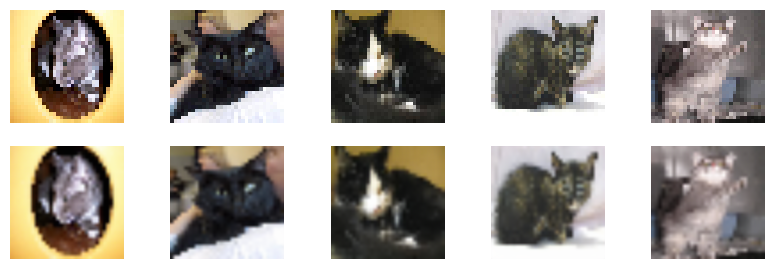

Epoch 125/150 | D Loss: 8.0590 | G Loss: 16.1764 | Perceptual Loss: 1.1662


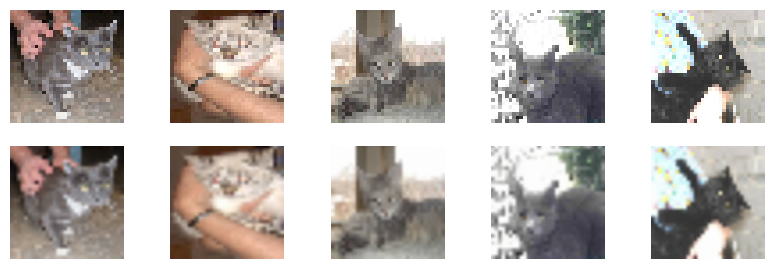

Epoch 126/150 | D Loss: 8.0590 | G Loss: 16.1754 | Perceptual Loss: 1.1456


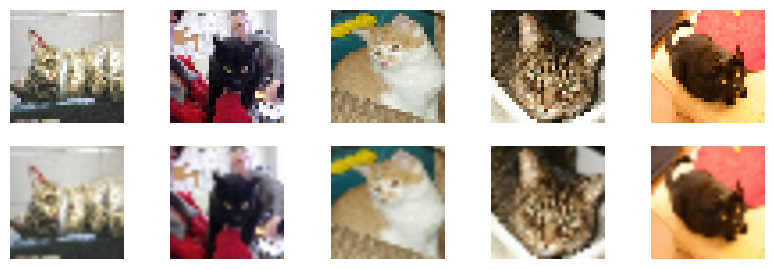

Epoch 127/150 | D Loss: 8.0590 | G Loss: 16.1747 | Perceptual Loss: 1.1313


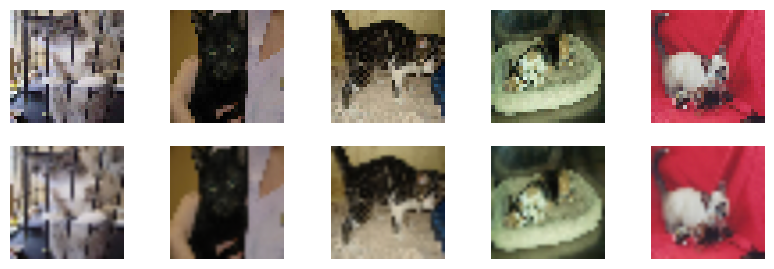

Epoch 128/150 | D Loss: 8.0590 | G Loss: 16.1742 | Perceptual Loss: 1.1228


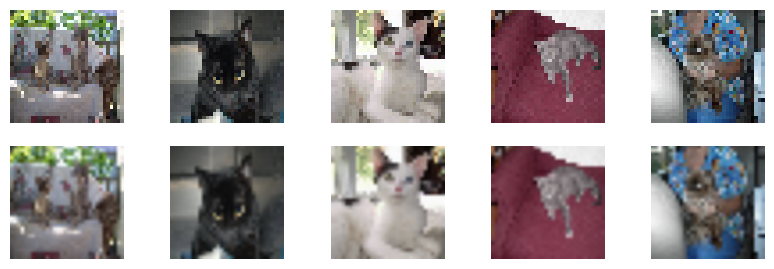

Epoch 129/150 | D Loss: 8.0590 | G Loss: 16.1739 | Perceptual Loss: 1.1158


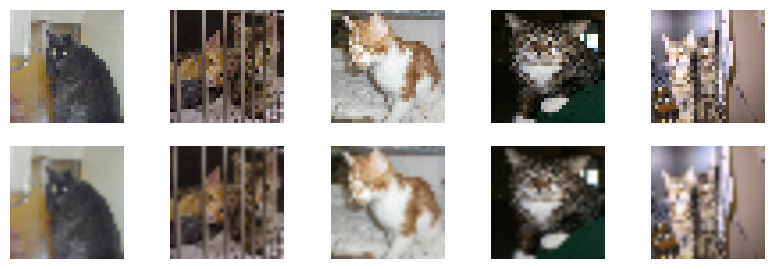

Epoch 130/150 | D Loss: 8.0590 | G Loss: 16.1736 | Perceptual Loss: 1.1098


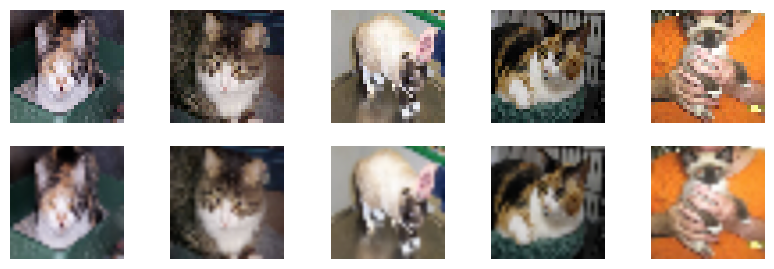

Epoch 131/150 | D Loss: 8.0590 | G Loss: 16.1733 | Perceptual Loss: 1.1045


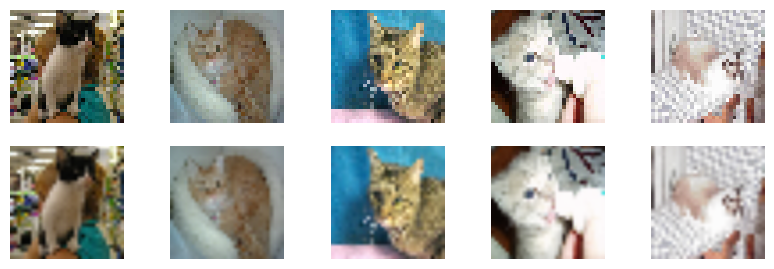

Epoch 132/150 | D Loss: 8.0590 | G Loss: 16.1731 | Perceptual Loss: 1.1000


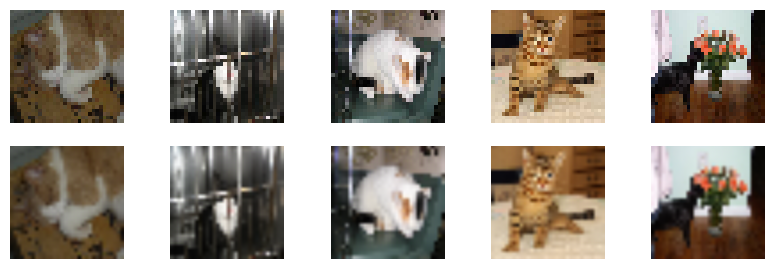

Epoch 133/150 | D Loss: 8.0590 | G Loss: 16.1729 | Perceptual Loss: 1.0953


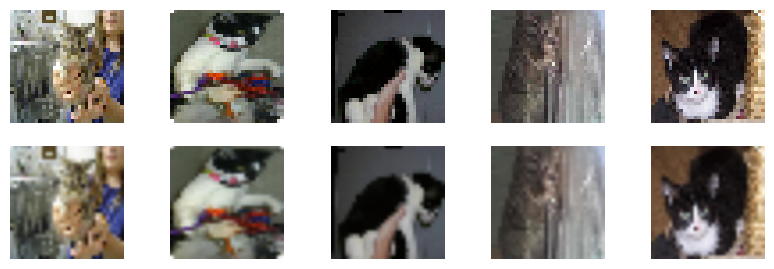

Epoch 134/150 | D Loss: 8.0590 | G Loss: 16.1727 | Perceptual Loss: 1.0916


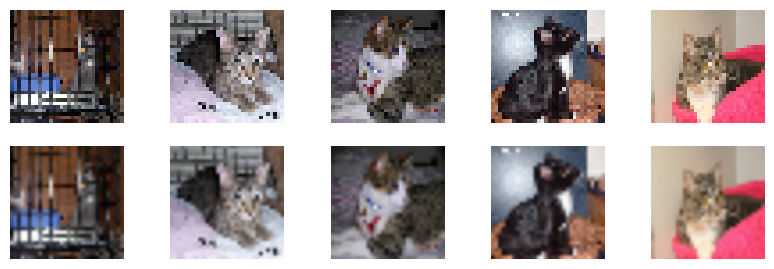

Epoch 135/150 | D Loss: 8.0590 | G Loss: 16.1725 | Perceptual Loss: 1.0885


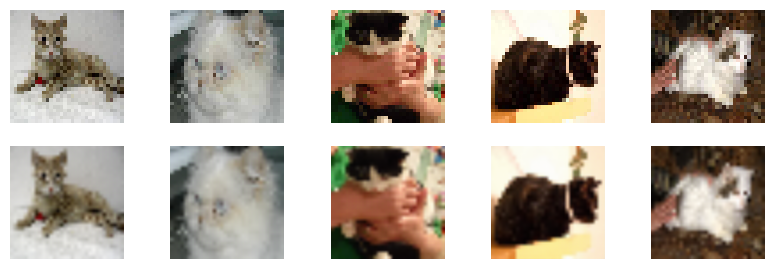

Epoch 136/150 | D Loss: 8.0590 | G Loss: 16.1723 | Perceptual Loss: 1.0849


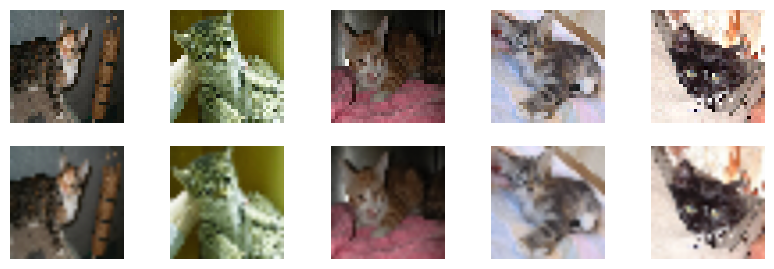

Epoch 137/150 | D Loss: 8.0590 | G Loss: 16.1722 | Perceptual Loss: 1.0829


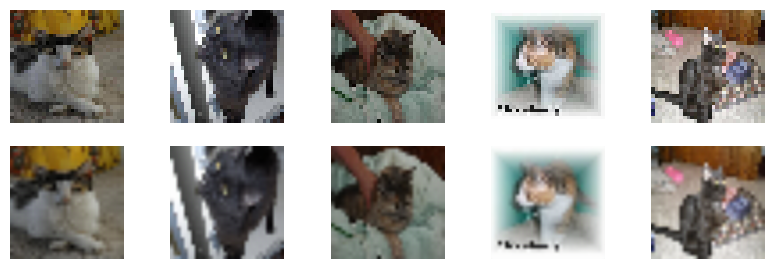

Epoch 138/150 | D Loss: 8.0590 | G Loss: 16.1721 | Perceptual Loss: 1.0802


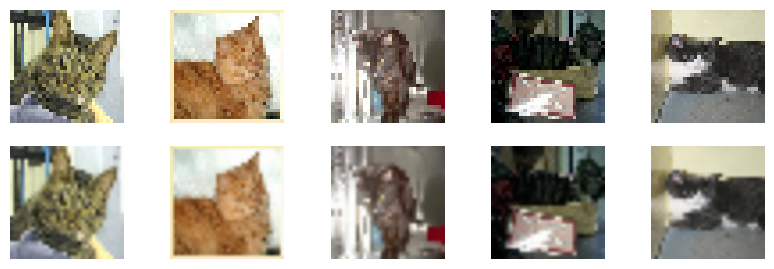

Epoch 139/150 | D Loss: 8.0590 | G Loss: 16.1720 | Perceptual Loss: 1.0778


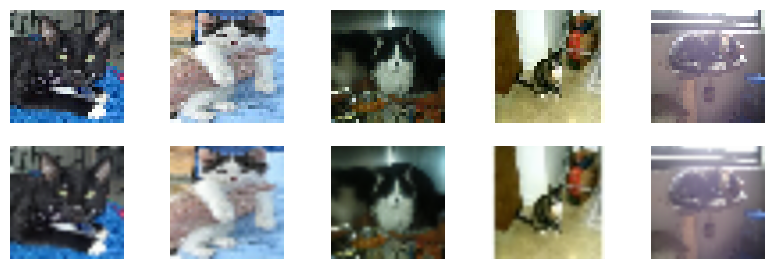

Epoch 140/150 | D Loss: 8.0590 | G Loss: 16.1718 | Perceptual Loss: 1.0747


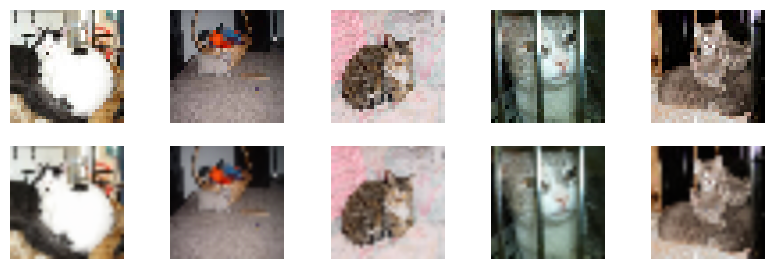

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Define the Discriminator Model Structure
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    for filters in [128, 256, 512]:
        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    outputs = Dense(1)(x)  # No activation for WGAN
    return Model(inputs, outputs)

# Define the Generator Model Structure
def build_generator(input_shape=(32, 32, 3), num_residual_blocks=12):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU()(x)
    for _ in range(num_residual_blocks):
        res = Conv2D(64, kernel_size=3, padding='same')(x)
        res = PReLU()(res)
        res = Conv2D(64, kernel_size=3, padding='same')(res)
        x = Add()([x, res])
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Load the saved models
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_124.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_124.keras"

# Rebuild the generator and load weights
generator = build_generator()
generator.load_weights(saved_generator_path)

# Rebuild the discriminator and load weights
discriminator = build_discriminator()
discriminator.load_weights(saved_discriminator_path)

# Set up a learning rate schedule
initial_lr = 2.5e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.9
)
generator_optimizer = Adam(lr_schedule, beta_1=0.5)
discriminator_optimizer = Adam(lr_schedule, beta_1=0.5)

# Set a perceptual loss weight
perceptual_loss_weight = 0.05  # Reduced perceptual loss weight

# Modify the VGG19 model to use multiple layers for feature extraction
def build_vgg19():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    layer_names = ['block3_conv4', 'block4_conv4', 'block5_conv4']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

# Rebuild VGG19 for perceptual loss with multiple layers
vgg_model = build_vgg19()

# Multi-layer perceptual loss
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    losses = [tf.reduce_mean(tf.square(real_features[i] - generated_features[i])) for i in range(len(real_features))]
    return sum(losses)

# Function to add noise to low-resolution images
def add_noise(image, noise_factor=0.02):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor)
    return image + noise

@tf.function
def train_step(real_imgs):
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])
    noisy_real_imgs = add_noise(tf.image.resize(real_imgs, [32, 32]), noise_factor=0.02)

    # Train Discriminator
    discriminator.trainable = True
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_imgs = generator(noisy_real_imgs, training=True)
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5

    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, discriminator.trainable_variables)]
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_real_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)  # Calculate perceptual loss
        g_loss = adv_loss + perceptual_loss_weight * perc_loss  # Total generator loss

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, generator.trainable_variables)]
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss), tf.reduce_mean(perc_loss)  # Return perceptual loss

# Training parameters
start_epoch = 123
epochs = 150
save_interval = 5  # Save every 5 epochs
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to display generated images
def show_generated_images(generator, dataset):
    real_images, _ = next(iter(dataset))
    low_res_images = tf.image.resize(real_images, [32, 32])
    generated_images = generator(low_res_images, training=False)

    low_res_images = (low_res_images + 1) / 2.0
    generated_images = (generated_images + 1) / 2.0
    real_images = (real_images + 1) / 2.0

    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(low_res_images[i])
        plt.axis('off')
        plt.subplot(3, 5, i + 6)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Training loop continued from epoch 123
for epoch in range(start_epoch, epochs):
    d_losses, g_losses, p_losses = [], [], []

    for real_imgs, _ in train_dataset:
        d_loss, g_loss, p_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        p_losses.append(p_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f} | Perceptual Loss: {np.mean(p_losses):.4f}")

    # Save models every 5 epochs
    if (epoch + 1) % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

    # Display generated images every epoch
    show_generated_images(generator, train_dataset)


Epoch 141/150 | D Loss: 8.0590 | G Loss: 16.1742 | Perceptual Loss: 1.1227


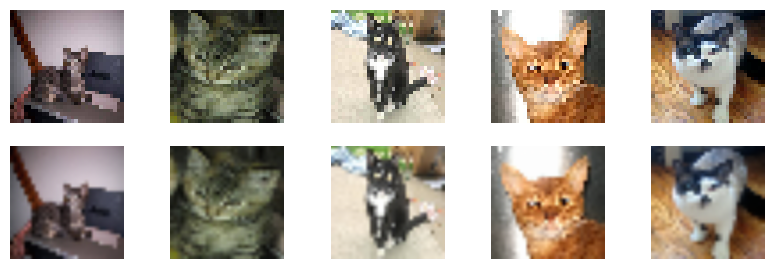

Epoch 142/150 | D Loss: 8.0590 | G Loss: 16.1738 | Perceptual Loss: 1.1147


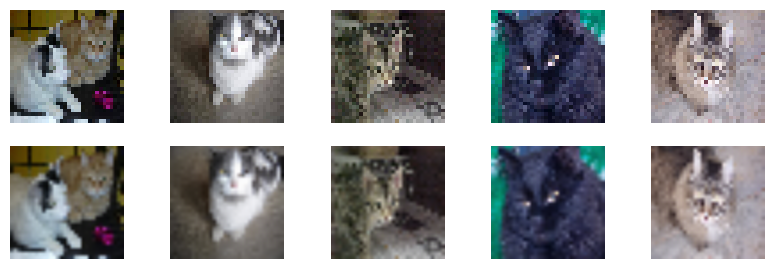

Epoch 143/150 | D Loss: 8.0590 | G Loss: 16.1736 | Perceptual Loss: 1.1092


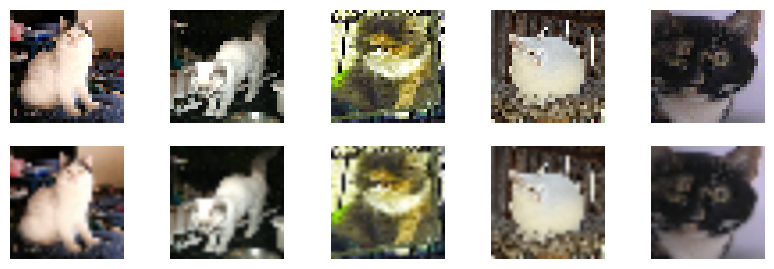

Epoch 144/150 | D Loss: 8.0590 | G Loss: 16.1733 | Perceptual Loss: 1.1044


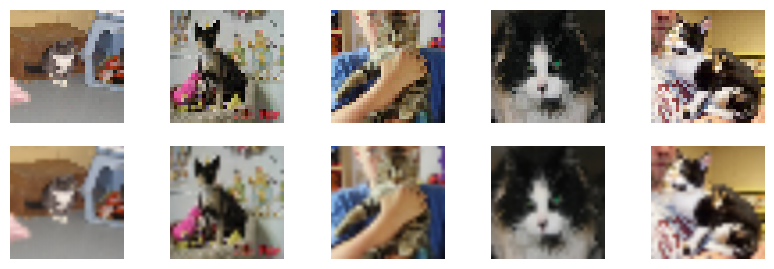

Epoch 145/150 | D Loss: 8.0590 | G Loss: 16.1731 | Perceptual Loss: 1.1009


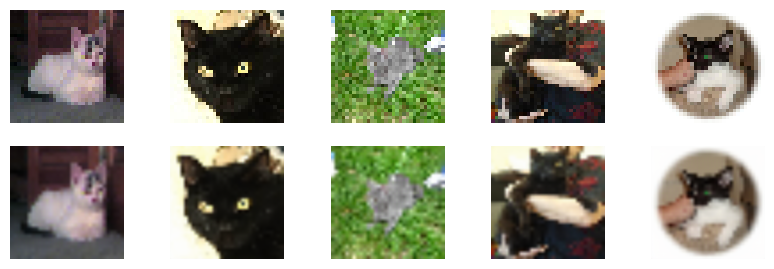

Epoch 146/150 | D Loss: 8.0590 | G Loss: 16.1728 | Perceptual Loss: 1.0948


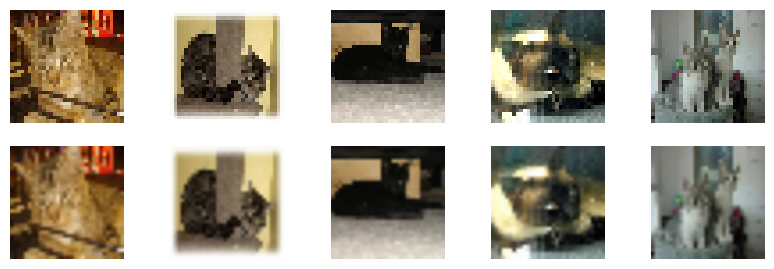

Epoch 147/150 | D Loss: 8.0590 | G Loss: 16.1727 | Perceptual Loss: 1.0921


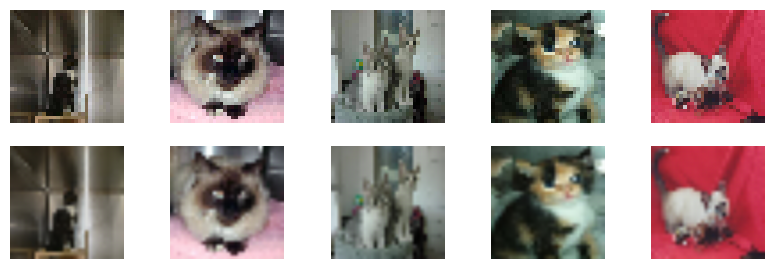

Epoch 148/150 | D Loss: 8.0590 | G Loss: 16.1724 | Perceptual Loss: 1.0869


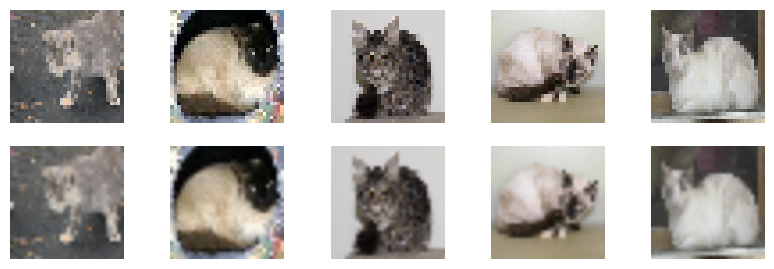

Epoch 149/150 | D Loss: 8.0590 | G Loss: 16.1723 | Perceptual Loss: 1.0844


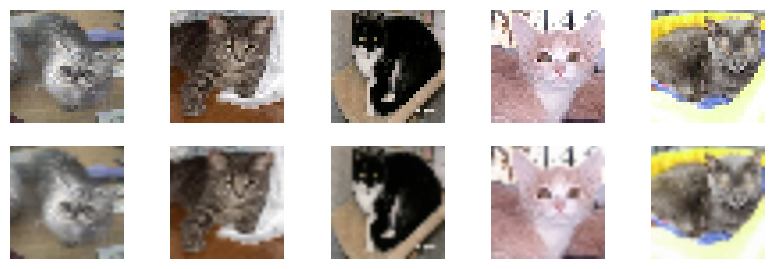

Epoch 150/150 | D Loss: 8.0590 | G Loss: 16.1722 | Perceptual Loss: 1.0818


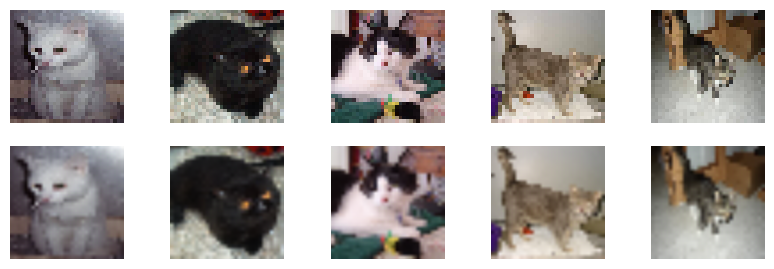

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, PReLU, Add, UpSampling2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG19

# Paths to dataset
train_dir = "/content/dataset/train"

# Helper function to load and preprocess images
def preprocess_image(file_path, target_size=(32, 32)):
    img = load_img(file_path.numpy(), target_size=target_size)
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1] for GAN
    return img

def load_dataset(directory, target_size=(32, 32), batch_size=32):
    cat_files = tf.data.Dataset.list_files(os.path.join(directory, 'cats', '*.jpg'))
    dog_files = tf.data.Dataset.list_files(os.path.join(directory, 'dogs', '*.jpg'))
    files = cat_files.concatenate(dog_files)

    def parse_image(file_path):
        img = tf.py_function(preprocess_image, [file_path], tf.float32)
        label = tf.cond(
            tf.strings.regex_full_match(file_path, ".*cat.*"),
            lambda: tf.constant(0, dtype=tf.int32),
            lambda: tf.constant(1, dtype=tf.int32)
        )
        img.set_shape([target_size[0], target_size[1], 3])
        return img, label

    dataset = files.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load datasets
train_dataset = load_dataset(train_dir, batch_size=16)

# Define the Discriminator Model Structure
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    for filters in [128, 256, 512]:
        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(0.2)(x)
    outputs = Dense(1)(x)  # No activation for WGAN
    return Model(inputs, outputs)

# Define the Generator Model Structure
def build_generator(input_shape=(32, 32, 3), num_residual_blocks=12):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=9, padding='same')(inputs)
    x = PReLU()(x)
    for _ in range(num_residual_blocks):
        res = Conv2D(64, kernel_size=3, padding='same')(x)
        res = PReLU()(res)
        res = Conv2D(64, kernel_size=3, padding='same')(res)
        x = Add()([x, res])
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(256, kernel_size=3, padding='same')(x)
    x = PReLU()(x)
    outputs = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    return Model(inputs, outputs)

# Load the saved models
saved_generator_path = "/content/drive/MyDrive/GAN_Models/generator_epoch_124.keras"
saved_discriminator_path = "/content/drive/MyDrive/GAN_Models/discriminator_epoch_124.keras"

# Rebuild the generator and load weights
generator = build_generator()
generator.load_weights(saved_generator_path)

# Rebuild the discriminator and load weights
discriminator = build_discriminator()
discriminator.load_weights(saved_discriminator_path)

# Set up a learning rate schedule
initial_lr = 2.5e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.9
)
generator_optimizer = Adam(lr_schedule, beta_1=0.5)
discriminator_optimizer = Adam(lr_schedule, beta_1=0.5)

# Set a perceptual loss weight
perceptual_loss_weight = 0.05  # Reduced perceptual loss weight

# Modify the VGG19 model to use multiple layers for feature extraction
def build_vgg19():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg.trainable = False
    layer_names = ['block3_conv4', 'block4_conv4', 'block5_conv4']
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model

# Rebuild VGG19 for perceptual loss with multiple layers
vgg_model = build_vgg19()

# Multi-layer perceptual loss
def perceptual_loss(real_imgs, generated_imgs):
    real_features = vgg_model(real_imgs)
    generated_features = vgg_model(generated_imgs)
    losses = [tf.reduce_mean(tf.square(real_features[i] - generated_features[i])) for i in range(len(real_features))]
    return sum(losses)

# Function to add noise to low-resolution images
def add_noise(image, noise_factor=0.02):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor)
    return image + noise

@tf.function
def train_step(real_imgs):
    real_imgs_128 = tf.image.resize(real_imgs, [128, 128])
    noisy_real_imgs = add_noise(tf.image.resize(real_imgs, [32, 32]), noise_factor=0.02)

    # Train Discriminator
    discriminator.trainable = True
    with tf.GradientTape() as tape:
        real_labels = tf.ones_like(discriminator(real_imgs_128)) * 0.9
        fake_imgs = generator(noisy_real_imgs, training=True)
        fake_labels = tf.zeros_like(discriminator(fake_imgs)) + 0.1
        real_loss = tf.keras.losses.binary_crossentropy(real_labels, discriminator(real_imgs_128))
        fake_loss = tf.keras.losses.binary_crossentropy(fake_labels, discriminator(fake_imgs))
        d_loss = (real_loss + fake_loss) * 0.5

    gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, discriminator.trainable_variables)]
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # Train Generator
    discriminator.trainable = False
    with tf.GradientTape() as tape:
        generated_imgs = generator(noisy_real_imgs, training=True)
        adv_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(discriminator(generated_imgs)), discriminator(generated_imgs))
        perc_loss = perceptual_loss(real_imgs_128, generated_imgs)  # Calculate perceptual loss
        g_loss = adv_loss + perceptual_loss_weight * perc_loss  # Total generator loss

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    gradients = [g if g is not None else tf.zeros_like(v) for g, v in zip(gradients, generator.trainable_variables)]
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return tf.reduce_mean(d_loss), tf.reduce_mean(g_loss), tf.reduce_mean(perc_loss)  # Return perceptual loss

# Training parameters
start_epoch = 140
epochs = 150
save_interval = 5  # Save every 5 epochs
save_dir = '/content/drive/MyDrive/GAN_Models/'

# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Helper function to display generated images
def show_generated_images(generator, dataset):
    real_images, _ = next(iter(dataset))
    low_res_images = tf.image.resize(real_images, [32, 32])
    generated_images = generator(low_res_images, training=False)

    low_res_images = (low_res_images + 1) / 2.0
    generated_images = (generated_images + 1) / 2.0
    real_images = (real_images + 1) / 2.0

    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(low_res_images[i])
        plt.axis('off')
        plt.subplot(3, 5, i + 6)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Training loop continued from epoch 123
for epoch in range(start_epoch, epochs):
    d_losses, g_losses, p_losses = [], [], []

    for real_imgs, _ in train_dataset:
        d_loss, g_loss, p_loss = train_step(real_imgs)
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        p_losses.append(p_loss)

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {np.mean(d_losses):.4f} | G Loss: {np.mean(g_losses):.4f} | Perceptual Loss: {np.mean(p_losses):.4f}")

    # Save models every 5 epochs
    if (epoch + 1) % save_interval == 0:
        generator.save(f"{save_dir}generator_epoch_{epoch}.keras")
        discriminator.save(f"{save_dir}discriminator_epoch_{epoch}.keras")

    # Display generated images every epoch
    show_generated_images(generator, train_dataset)
